<a href="https://colab.research.google.com/github/alexlimatds/victor-doc_classification/blob/main/victor_doc_classification_CNN4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Document classification of Victor project using a CNN as machine learning model

The notebook replicates the document classification with a CNN described in the _VICTOR: a Dataset for Brazilian Legal Documents Classification_ paper. In addition, it uses weights in the loss function to compesate the data imbalance.

- Deep learning library: PyTorch
- NLP Library: spaCy

### Instaling dependencies

In [ ]:
!pip install tqdm
!python -m spacy download pt

     |████████████████████████████████| 21.2MB 1.2MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-cp36-none-any.whl size=21186283 sha256=7977a9d5f772dafa32231147b827bb307295c2f5bc3fb717eb48b5ba027318b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-1wg8w3ay/wheels/ea/94/74/ec9be8418e9231b471be5dc7e1b45dd670019a376a6b5bc1c0
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


### Application parameters

In [ ]:
from datetime import datetime

S = 500 # sentence length
BATCH_SIZE = 64
NUM_OF_CLASSES = 6

L2 = 0.001

MLP_HIDDEN_UNITS = 128
EMBEDDING_DIM = 100

dataset_dir = root_dir + 'Machine Learning/Victor datasets/'
model_path = '/'
model_file = model_path + f'pytorch_model-{S}-.pt'

now = datetime.now().strftime('%Y%m%d_%H%M%S')
report_file = dataset_dir + f'CNN_4/report-{S}-L2_{L2}-{now}.txt'

### Loading and preprocessing datasets

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
from tqdm.notebook import trange, tqdm_notebook
import numpy as np
from datetime import datetime

In [ ]:
import spacy

spacy_pt = spacy.load('pt')

def tokenizer(text):
  return [tok.text for tok in spacy_pt.tokenizer(text)]


In [ ]:
%%time

TEXT = data.Field(
    tokenize=tokenizer, 
    lower=True, 
    fix_length=S)
LABEL = data.Field(
    sequential=False, 
    unk_token=None)

train_data, valid_data, test_data = data.TabularDataset.splits(
    path=dataset_dir, 
    train='train_small.csv',
    validation='validation_small.csv', 
    test='test_small.csv', 
    format='csv', 
    skip_header = True, 
    fields=[(None, None), (None, None), (None, None), ('label', LABEL), (None, None), ('text', TEXT)])

CPU times: user 5min 8s, sys: 3.55 s, total: 5min 12s
Wall time: 5min 14s


In [ ]:
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
  (train_data, valid_data, test_data),
  sort = False, #don't sort test/validation data
  batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
  device=device)

### Model

In [ ]:
class VictorCNN(nn.Module):

  def __init__(self, sentence_len, vocab_size, embed_dim, n_classes, mlp_h):
    """
    sentence_len: the length of the each input sentence.
    vocab_size:   the number of tokens in the vocabulary.
    embed_dim:    the dimension of each embedding word vector.
    n_classes:    number of classes, i.e., the output dimension of this NN.
    mlp_h:        number of hidden units of the MLP NN.
    """
    super(VictorCNN, self).__init__()
        
    self.word_embeddings = nn.Embedding(vocab_size, embed_dim)
    self.cnn_a = self.create_cnn_layer(embed_dim, 256, 3, 1)
    self.cnn_b = self.create_cnn_layer(embed_dim, 256, 4, 2)
    self.cnn_c = self.create_cnn_layer(embed_dim, 256, 5, 2)
    self.max_pool = nn.MaxPool1d(50)
    self.linear_h = nn.Linear(3840, mlp_h)
    self.linear_o = nn.Linear(mlp_h, n_classes)

  def create_cnn_layer(self, n_channels, n_filters, kernel_size, padding):
    return nn.Sequential(
        nn.Conv1d(n_channels, n_filters, kernel_size, padding=padding), 
        nn.BatchNorm1d(n_filters), 
        nn.MaxPool1d(2)
    )

  def forward(self, sentence):
    # sentence.shape: (s_len, b_len)
    embeds = self.word_embeddings(sentence).permute(1, 2, 0) # embeds shape: (b_len, embedding_dim, s_len)
    a = self.cnn_a(embeds)
    b = self.cnn_b(embeds)
    c = self.cnn_c(embeds)
    x = torch.cat((a, b, c), dim=1)
    x = self.max_pool(x)
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.linear_h(x))
    x = self.linear_o(x)
    return x

### Training functions

In [ ]:
from sklearn.metrics import f1_score

def compute_metrics(targets, predictions):
  f1_macro = f1_score(targets, np.argmax(predictions, axis=1), average='macro')
  return f1_macro

def train(model, iterator, optimizer, criterion, epoch):
  epoch_loss = 0
  model.train()
  for batch in tqdm_notebook(iterator, desc='Train', unit='batch', leave=False):
    optimizer.zero_grad()
    predictions = model(batch.text)
    loss = criterion(predictions, batch.label)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  return epoch_loss / len(iterator)

def predict(model, iterator, set_name):
  model.eval()
  predictions = None
  targets = None
  with torch.no_grad():
    for batch in tqdm_notebook(iterator, desc=f'Predicting ({set_name})', unit='batch', leave=False):
      out = model(batch.text)
      if predictions == None:
        predictions = out
        targets = batch.label
      else:
        predictions = torch.cat([predictions, out], dim=0)
        targets = torch.cat([targets, batch.label], dim=0)
  
  return predictions.cpu().numpy(), targets.cpu().numpy()

def evaluate(model, iterator, set_name):  
  predictions, targets = predict(model, iterator, set_name)
  return compute_metrics(targets, predictions)


### Training

In [ ]:
EPOCHS = 30
learning_rate = 1e-3

model = VictorCNN(S, len(TEXT.vocab), EMBEDDING_DIM, NUM_OF_CLASSES, MLP_HIDDEN_UNITS)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2)

# class weights - the number of instances for each class is informed in the paper
'''
c_n_dict = {
    'outros': 134134, 
    'peticao_do_RE': 9509, 
    'agravo_em_recurso_extraordinario': 2546, 
    'sentenca': 2129, 
    'acordao_de_2_instancia': 553, 
    'despacho_de_admissibilidade': 346}
total_instances = 149217.0
c_w = torch.zeros(6)
for i, label in enumerate(LABEL.vocab.itos):
  c_w[i] = 1.0 / c_n_dict[label]
c_w = c_w / c_w.sum()
'''
c_w_dict = {
    'outros': 0.1, 
    'peticao_do_RE': 1.0, 
    'agravo_em_recurso_extraordinario': 1.0, 
    'sentenca': 1.0, 
    'acordao_de_2_instancia': 2.0, 
    'despacho_de_admissibilidade': 2.0}
c_w = torch.zeros(6)
for i, label in enumerate(LABEL.vocab.itos):
  c_w[i] = c_w_dict[label]

print('Class weights: ', c_w)

criterion = nn.CrossEntropyLoss(weight=c_w)
criterion = criterion.to(device)

Class weights:  tensor([0.1000, 1.0000, 1.0000, 1.0000, 2.0000, 2.0000])


In [ ]:
%%time
import pandas as pd
from IPython.display import display, update_display

metrics_df = pd.DataFrame(columns=['Epoch', 'Loss (train)', 'F1 macro (train)', 'F1 macro (validation)'])
metrics_display = display(metrics_df, display_id='metrics_table')

best_valid_f1 = 0.0

for epoch in range(EPOCHS):
  train_loss = train(model, train_iterator, optimizer, criterion, epoch)
  train_f1_m = evaluate(model, train_iterator, 'train set')
  valid_f1_m = evaluate(model, valid_iterator, 'validation set')
  
  #saving
  if valid_f1_m > best_valid_f1:
    best_valid_f1 = valid_f1_m
    torch.save(model.state_dict(), model_file)

  #printing
  metrics_df.loc[epoch] = [epoch + 1, train_loss, train_f1_m, valid_f1_m]
  metrics_display.update(metrics_df)

,Epoch,Loss (train),F1 macro (train),F1 macro (validation)
0,1.0,0.891149,0.419785,0.429809
1,2.0,0.608383,0.584574,0.535494
2,3.0,0.445039,0.537600,0.489069
3,4.0,0.366741,0.592638,0.523111
4,5.0,0.326666,0.674543,0.583412
5,6.0,0.301667,0.705502,0.610461
6,7.0,0.283992,0.683367,0.601899
7,8.0,0.269229,0.731839,0.648832
8,9.0,0.255929,0.728012,0.636463
9,10.0,0.249236,0.745614,0.656084


CPU times: user 55min 12s, sys: 27min 25s, total: 1h 22min 38s
Wall time: 1h 23min 29s


### Evaluation

In [ ]:
def load_saved_model(file_name):
  m = VictorCNN(S, len(TEXT.vocab), EMBEDDING_DIM, NUM_OF_CLASSES, MLP_HIDDEN_UNITS)
  m = m.to(device)
  m.load_state_dict(torch.load(file_name, map_location=device))
  m.eval()
  return m

model = load_saved_model(model_file)

In [ ]:
train_predictions, train_targets = predict(model, train_iterator, 'train set')
valid_predictions, valid_targets = predict(model, valid_iterator, 'validation set')
test_predictions, test_targets = predict(model, test_iterator, 'test set')

In [ ]:
from sklearn.metrics import classification_report

test_report = classification_report(
    test_targets, 
    np.argmax(test_predictions, axis=1), 
    digits=4, 
    target_names=LABEL.vocab.itos)

valid_report = classification_report(
    valid_targets, 
    np.argmax(valid_predictions, axis=1), 
    digits=4, 
    target_names=LABEL.vocab.itos)

train_report = classification_report(
    train_targets, 
    np.argmax(train_predictions, axis=1), 
    digits=4, 
    target_names=LABEL.vocab.itos)

def format_int(value):
  value = int(value)
  return f'{value:2d}'

def format_float(value):
  return f'{value:.4f}'

print('Test\n' + test_report)

rep_file = open(report_file, "wt")
rep_file.write('CNN 4 evaluation report\n')
rep_file.write(f'L2 rate: {L2}\n')
rep_file.write(f'learning rate: {learning_rate}\n')
rep_file.write(f'optimizer: {type(optimizer).__name__}\n')
rep_file.write(f'criterion: {type(criterion).__name__}\n')
rep_file.write(f'MLP_HIDDEN_UNITS: {MLP_HIDDEN_UNITS}\n')
rep_file.write(f'EMBEDDING_DIM: {EMBEDDING_DIM}\n')
rep_file.write(f'Class weights:\n')
for i, label in enumerate(LABEL.vocab.itos):
  rep_file.write(f'\t{label}: {c_w[i]}\n')
rep_file.write(f'Test\n{test_report}\n')
rep_file.write(f'Validation\n{valid_report}\n')
rep_file.write(f'Train\n{train_report}\n')
rep_file.write(f'Train log\n {metrics_df.to_string(index=False, formatters=[format_int, format_float, format_float, format_float])}\n')
rep_file.close()

Test
                                  precision    recall  f1-score   support

                          outros     0.9775    0.9152    0.9454     85408
                   peticao_do_RE     0.4987    0.7973    0.6136      6331
agravo_em_recurso_extraordinario     0.4294    0.6143    0.5055      1841
                        sentenca     0.5876    0.8183    0.6840      1475
          acordao_de_2_instancia     0.4866    0.9304    0.6390       273
     despacho_de_admissibilidade     0.5696    0.6616    0.6121       198

                        accuracy                         0.8996     95526
                       macro avg     0.5916    0.7895    0.6666     95526
                    weighted avg     0.9270    0.8996    0.9093     95526



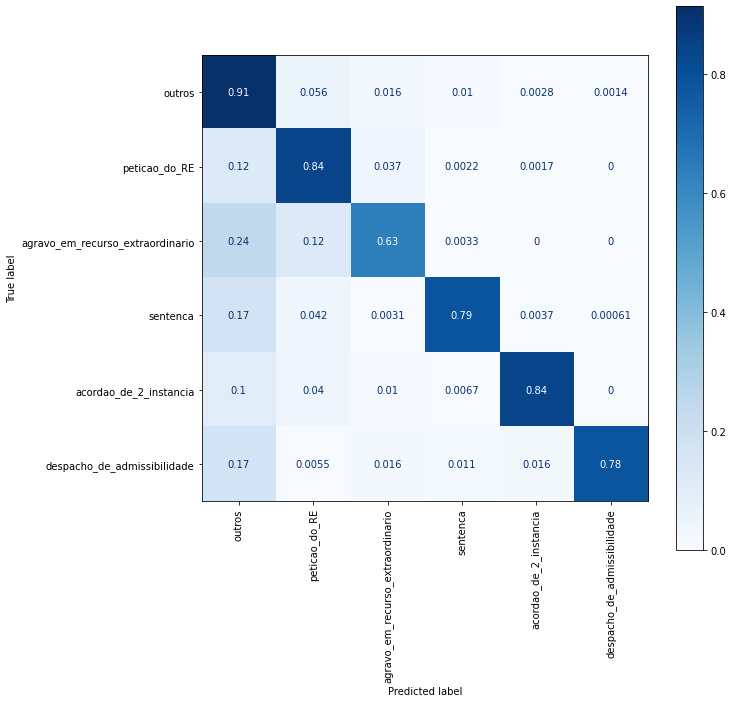

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(valid_targets, np.argmax(valid_predictions, axis=1), normalize='true')
f = plt.figure(figsize=(10,10))
ax = f.add_subplot()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL.vocab.itos)
disp.plot(xticks_rotation='vertical', cmap=plt.cm.Blues, ax=ax)
f.savefig(report_file + '.pdf', bbox_inches='tight')